In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "IGH_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-IgSub-IGH_HUMAN-after-reassignment.csv',
 'cdr3-clones-Vasculitis-IGH_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20200218_MSrun037_pt-table-new.csv"
run = "run37"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
print("Outfile:", plotfile)

Outfile: run37-similarity-IGH_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,ID386t1-B_S31,CGTACGTA,CAKDLGPYNWNYQWGQGTLVT,484,250,IGHV3-48,"IGHJ5,IGHJ4",12,0.024793,0.539000,0.456421
1,ID386t1-B_S31,CGTACGTA,CAREKDYGDSSFDYWGQGTLVT,305,174,IGHV4-30-4,IGHJ4,17,0.055738,0.339659,0.317669
2,ID386t1-B_S31,CGTACGTA,CAHRLPPADYDFWSGYFDYWGQGTLVT,301,167,IGHV2-5,IGHJ4,6,0.019934,0.335204,0.304889
3,ID386t1-B_S31,CGTACGTA,CAHCDYTKWENYFDYWGQGTLVT,292,155,IGHV2-5,IGHJ4,10,0.034247,0.325182,0.282981
4,ID386t1-B_S31,CGTACGTA,CALLAPDVGVWGNGTTVT,261,209,IGHV3-74,IGHJ6,265,1.015326,0.290659,0.381568


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
355776,VC018V2-IgG-LIN_S22,CAKGLIGACSGARCYPFDLWGQGILVT,3,3,0,0.0,8.333333,8.333333
355787,VC018V2-IgG-LIN_S22,CARMFGTYKNYFDPWGQGTLVT,3,3,0,0.0,8.333333,8.333333
355794,VC018V2-IgG-LIN_S22,CVRDTYLNYGMDVWGQGTTVT,3,3,0,0.0,8.333333,8.333333
355773,VC018V2-IgG-LIN_S22,CAKDHHYYHSSGGLNYFDSWGLGTLVT,2,2,0,0.0,5.555556,5.555556
355774,VC018V2-IgG-LIN_S22,CAKEGVRGYFPDWGQGTLVT,2,2,0,0.0,5.555556,5.555556


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=";")
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Samples order,Sample_ID,Sample name,MID,Project,Species,Chain,Patient,SampleInfo,UMI (yes or no)
0,S1,N701_S502,IgSub-UMI1,NaN,IgSub,human,IgG,ID596,IgG UMI,yes
1,S2,N702_S502,IgSub-UMI2,NaN,IgSub,human,IgG,ID629,IgG UMI,yes
2,S3,N703_S502,IgSub-UMI3,NaN,IgSub,human,IgG,ID657,IgG UMI,yes
3,S4,N704_S502,IgSub-UMI4,NaN,IgSub,human,IgG,ID638,IgG UMI,yes
4,S5,N705_S502,IgSub-UMI5,NaN,IgSub,human,IgG,ID598,IgG UMI,yes


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample name'], pt['Samples order'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,IgSub-UMI1_S1,ID596
1,IgSub-UMI2_S2,ID629
2,IgSub-UMI3_S3,ID657
3,IgSub-UMI4_S4,ID638
4,IgSub-UMI5_S5,ID598


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,VC018V2-IgG-LIN_S22,CAKGLIGACSGARCYPFDLWGQGILVT,3,3,0,0.0,8.333333,8.333333,VC018V2
1,VC018V2-IgG-LIN_S22,CARMFGTYKNYFDPWGQGTLVT,3,3,0,0.0,8.333333,8.333333,VC018V2
2,VC018V2-IgG-LIN_S22,CVRDTYLNYGMDVWGQGTTVT,3,3,0,0.0,8.333333,8.333333,VC018V2
3,VC018V2-IgG-LIN_S22,CAKDHHYYHSSGGLNYFDSWGLGTLVT,2,2,0,0.0,5.555556,5.555556,VC018V2
4,VC018V2-IgG-LIN_S22,CAKEGVRGYFPDWGQGTLVT,2,2,0,0.0,5.555556,5.555556,VC018V2


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                         ID386                               \
Sample                  ID386t1-B_S31 IgSub-LIn6_S20 IgSub-UMI6_S6   
cdr3pep                                                              
AAYGSGKLYYYGMDVWGQGTTVT           0.0            0.0           0.0   
AFAENKWFGGHWIDPWGQGILVT           0.0            0.0           0.0   
AFAENKWSGGHWIDPWGQGILVT           0.0            0.0           0.0   
AFDIWGQGTMVT                      0.0            0.0           0.0   
AFLEWPNYYYYDMDVWGKGTTVT           0.0            0.0           0.0   

Patient                         ID596                               \
Sample                  ID596t0-B_S25 IgSub-LIN1_S15 IgSub-UMI1_S1   
cdr3pep                                                              
AAYGSGKLYYYGMDVWGQGTTVT           0.0            0.0           0.0   
AFAENKWFGGHWIDPWGQGILVT           0.0            0.0           0.0   
AFAENKWSGGHWIDPWGQGILVT           0.0            0.0           0.0   
AFDIWGQGTMVT                      0.0            0.0           0.0   
AFLEWPNYYYYDMDVWGKGTTVT           0.0            0.0           0.0   

Patient                         ID598                               \
Sample                  ID598t0-B_S26 IgSub-LIN5_S19 IgSub-UMI5_S5   
cdr3pep                                                              
AAYGSGKLYYYGMDVWGQGTTVT           2.0            0.0           0.0   
AFAENKWFGGHWIDPWGQGILVT           0.0            0.0           0.0   
AFAENKWSGGHWIDPWGQGILVT           0.0            0.0           0.0   
AFDIWGQGTMVT                      5.0            0.0           0.0   
AFLEWPNYYYYDMDVWGKGTTVT           0.0            0.0           0.0   

Patient                         ID629         ...                 PRIK004  \
Sample                  ID629t0-B_S27         ...         IgSub-UMI10_S10   
cdr3pep                                       ...                           
AAYGSGKLYYYGMDVWGQGTTVT           0.0         ...                     0.0   
AFAENKWFGGHWIDPWGQGILVT          10.0         ...                     0.0   
AFAENKWSGGHWIDPWGQGILVT           1.0         ...                     0.0   
AFDIWGQGTMVT                      0.0         ...                     0.0   
AFLEWPNYYYYDMDVWGKGTTVT           0.0         ...                     0.0   

Patient                                                                  \
Sample                  IgSub-UMI11_S11 IgSub-UMI12_S12 IgSub-UMI13_S13   
cdr3pep                                                                   
AAYGSGKLYYYGMDVWGQGTTVT             0.0             0.0             0.0   
AFAENKWFGGHWIDPWGQGILVT             0.0             0.0             0.0   
AFAENKWSGGHWIDPWGQGILVT             0.0             0.0             0.0   
AFDIWGQGTMVT                        0.0             0.0             0.0   
AFLEWPNYYYYDMDVWGKGTTVT             0.0             0.0             0.0   

Patient                                                              \
Sample                  IgSub-UMI14_S14 IgSub-UMI8_S8 IgSub-UMI9_S9   
cdr3pep                                                               
AAYGSGKLYYYGMDVWGQGTTVT             0.0           0.0           0.0   
AFAENKWFGGHWIDPWGQGILVT             0.0           0.0           0.0   
AFAENKWSGGHWIDPWGQGILVT             0.0           0.0           0.0   
AFDIWGQGTMVT                        0.0           0.0           0.0   
AFLEWPNYYYYDMDVWGKGTTVT             0.0           0.0           0.0   

Patient                                               VC015V3  \
Sample                  Prik004-2nd-B_S24 VC015V3-IgG-LIN_S23   
cdr3pep                                                         
AAYGSGKLYYYGMDVWGQGTTVT               0.0                 0.0   
AFAENKWFGGHWIDPWGQGILVT               0.0                 0.0   
AFAENKWSGGHWIDPWGQGILVT               0.0                 0.0   
AFDIWGQGTMVT                          0.0                 0.0   
AFLEWPNYYYYDMDVWGKGTTVT               0.0                 0.0   

Patient  

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                        ID386                               \
Sample                 ID386t1-B_S31 IgSub-LIn6_S20 IgSub-UMI6_S6   
Patient Sample                                                      
ID386   ID386t1-B_S31       1.000000       0.042928      0.044404   
        IgSub-LIn6_S20      0.042928       1.000000      0.076037   
        IgSub-UMI6_S6       0.044404       0.076037      1.000000   
ID596   ID596t0-B_S25       0.000149       0.000000      0.000000   
        IgSub-LIN1_S15      0.000103       0.000000      0.000039   

Patient                        ID596                               \
Sample                 ID596t0-B_S25 IgSub-LIN1_S15 IgSub-UMI1_S1   
Patient Sample                                                      
ID386   ID386t1-B_S31       0.000149       0.000103      0.000000   
        IgSub-LIn6_S20      0.000000       0.000000      0.000078   
        IgSub-UMI6_S6       0.000000       0.000039      0.000061   
ID596   ID596t0-B_S25       1.000000       0.050020      0.045268   
        IgSub-LIN1_S15      0.050020       1.000000      0.093268   

Patient                        ID598                               \
Sample                 ID598t0-B_S26 IgSub-LIN5_S19 IgSub-UMI5_S5   
Patient Sample                                                      
ID386   ID386t1-B_S31       0.000490       0.000013      0.000023   
        IgSub-LIn6_S20      0.000023       0.000047      0.000189   
        IgSub-UMI6_S6       0.000052       0.000103      0.000256   
ID596   ID596t0-B_S25       0.000393       0.000090      0.000010   
        IgSub-LIN1_S15      0.000052       0.000009      0.000068   

Patient                        ID629         ...                 PRIK004  \
Sample                 ID629t0-B_S27         ...         IgSub-UMI10_S10   
Patient Sample                               ...                           
ID386   ID386t1-B_S31       0.000415         ...                0.000000   
        IgSub-LIn6_S20      0.000015         ...                0.000036   
        IgSub-UMI6_S6       0.000035         ...                0.000187   
ID596   ID596t0-B_S25       0.000262         ...                0.000000   
        IgSub-LIN1_S15      0.000060         ...                0.000460   

Patient                                                                 \
Sample                 IgSub-UMI11_S11 IgSub-UMI12_S12 IgSub-UMI13_S13   
Patient Sample                                                           
ID386   ID386t1-B_S31         0.000000        0.000000        0.000027   
        IgSub-LIn6_S20        0.000491        0.000067        0.000000   
        IgSub-UMI6_S6         0.000395        0.000213        0.000232   
ID596   ID596t0-B_S25         0.000000        0.000008        0.000000   
        IgSub-LIN1_S15        0.002197        0.000407        0.000391   

Patient                                                             \
Sample                 IgSub-UMI14_S14 IgSub-UMI8_S8 IgSub-UMI9_S9   
Patient Sample                                                       
ID386   ID386t1-B_S31         0.000044      0.000010      0.000000   
        IgSub-LIn6_S20        0.000058      0.000054      0.000047   
        IgSub-UMI6_S6         0.000212      0.000198      0.000178   
ID596   ID596t0-B_S25         0.000008      0.000009      0.000016   
        IgSub-LIN1_S15        0.000169      0.000453      0.000410   

Patient                                              VC015V3  \
Sample                 Prik004-2nd-B_S24 VC015V3-IgG-LIN_S23   
Patient Sample                                                 
ID386   ID386t1-B_S31           0.000220            0.000000   
        IgSub-LIn6_S20          0.000009            0.000000   
        IgSub-UMI6_S6           0.000091            0.000000   
ID596   ID596t0-B_S25           0.000313            0.000000   
        IgSub-LIN1_S15          0.000185            0.000268   

Patient                            VC018V2  
Sample              

## Create a heatmap

In [13]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [14]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 5.717209658695488e-06
max value: 1.0
Wrote run37-similarity-IGH_HUMAN.pdf to disk


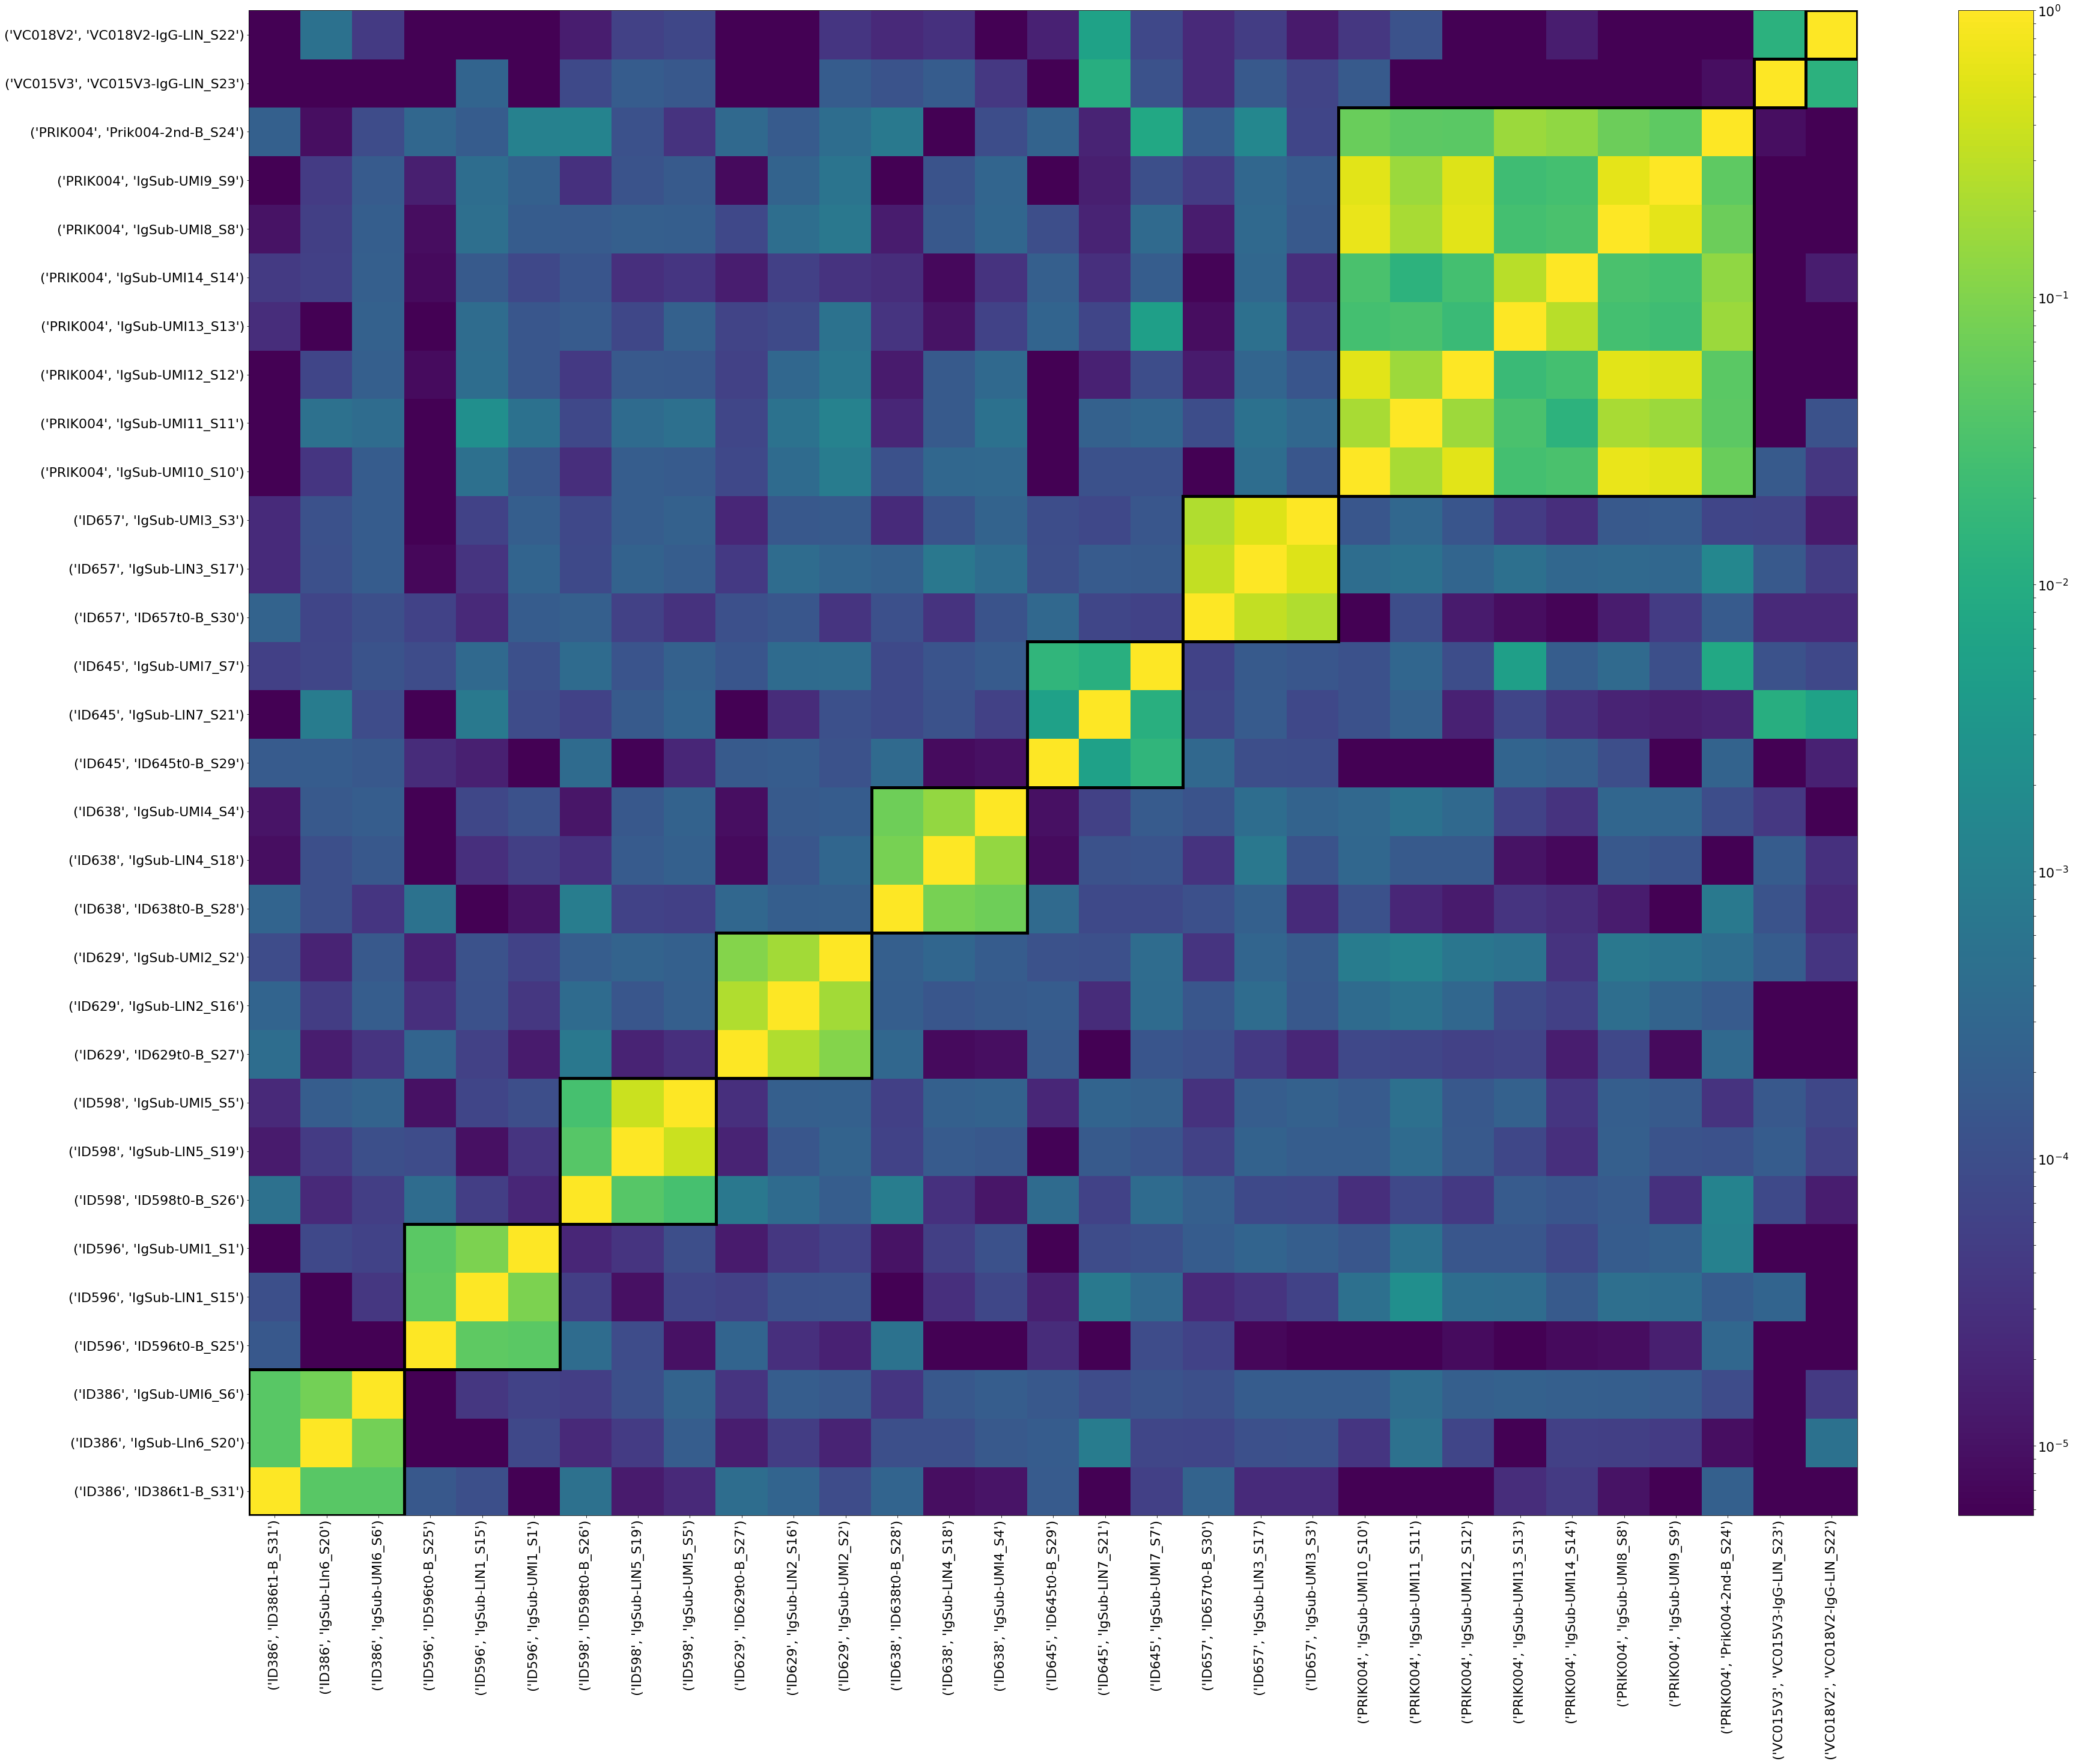

In [15]:
drawHeatmap(sim)

## Highlight anomalies

In [16]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [17]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.16622607868499012 0.19021187025112507
mean diff patient 0.00025903654145409513 0.0009948703927916576
threshold 0.004238518112620725


{'whiskers': [<matplotlib.lines.Line2D at 0x7fe77a3ae470>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe77a3aed30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe77a3ae320>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe77a3645c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe77a3649e8>,
 'means': []}

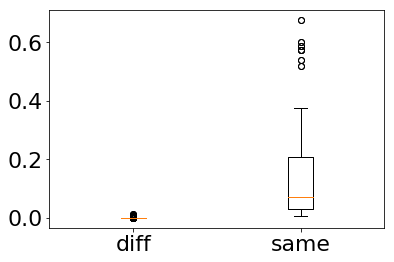

In [18]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

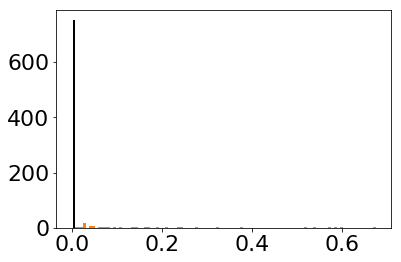

In [19]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [20]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('ID645', 'IgSub-LIN7_S21') ('VC015V3', 'VC015V3-IgG-LIN_S23') 0.011001100110010986
('ID645', 'IgSub-LIN7_S21') ('VC018V2', 'VC018V2-IgG-LIN_S22') 0.005979073243647215
('ID645', 'IgSub-UMI7_S7') ('PRIK004', 'IgSub-UMI13_S13') 0.005036961878533086
('ID645', 'IgSub-UMI7_S7') ('PRIK004', 'Prik004-2nd-B_S24') 0.007942723726208745
('PRIK004', 'IgSub-UMI13_S13') ('ID645', 'IgSub-UMI7_S7') 0.005036961878533086
('PRIK004', 'Prik004-2nd-B_S24') ('ID645', 'IgSub-UMI7_S7') 0.007942723726208745
('VC015V3', 'VC015V3-IgG-LIN_S23') ('ID645', 'IgSub-LIN7_S21') 0.011001100110010986
('VC015V3', 'VC015V3-IgG-LIN_S23') ('VC018V2', 'VC018V2-IgG-LIN_S22') 0.012820512820512775
('VC018V2', 'VC018V2-IgG-LIN_S22') ('ID645', 'IgSub-LIN7_S21') 0.005979073243647215
('VC018V2', 'VC018V2-IgG-LIN_S22') ('VC015V3', 'VC015V3-IgG-LIN_S23') 0.012820512820512775
Wrote run37-similarity-IGH_HUMAN.txt to disk


In [21]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 5.717209658695488e-06
max value: 1.0
Wrote run37-similarity-IGH_HUMAN-highlighted.pdf to disk


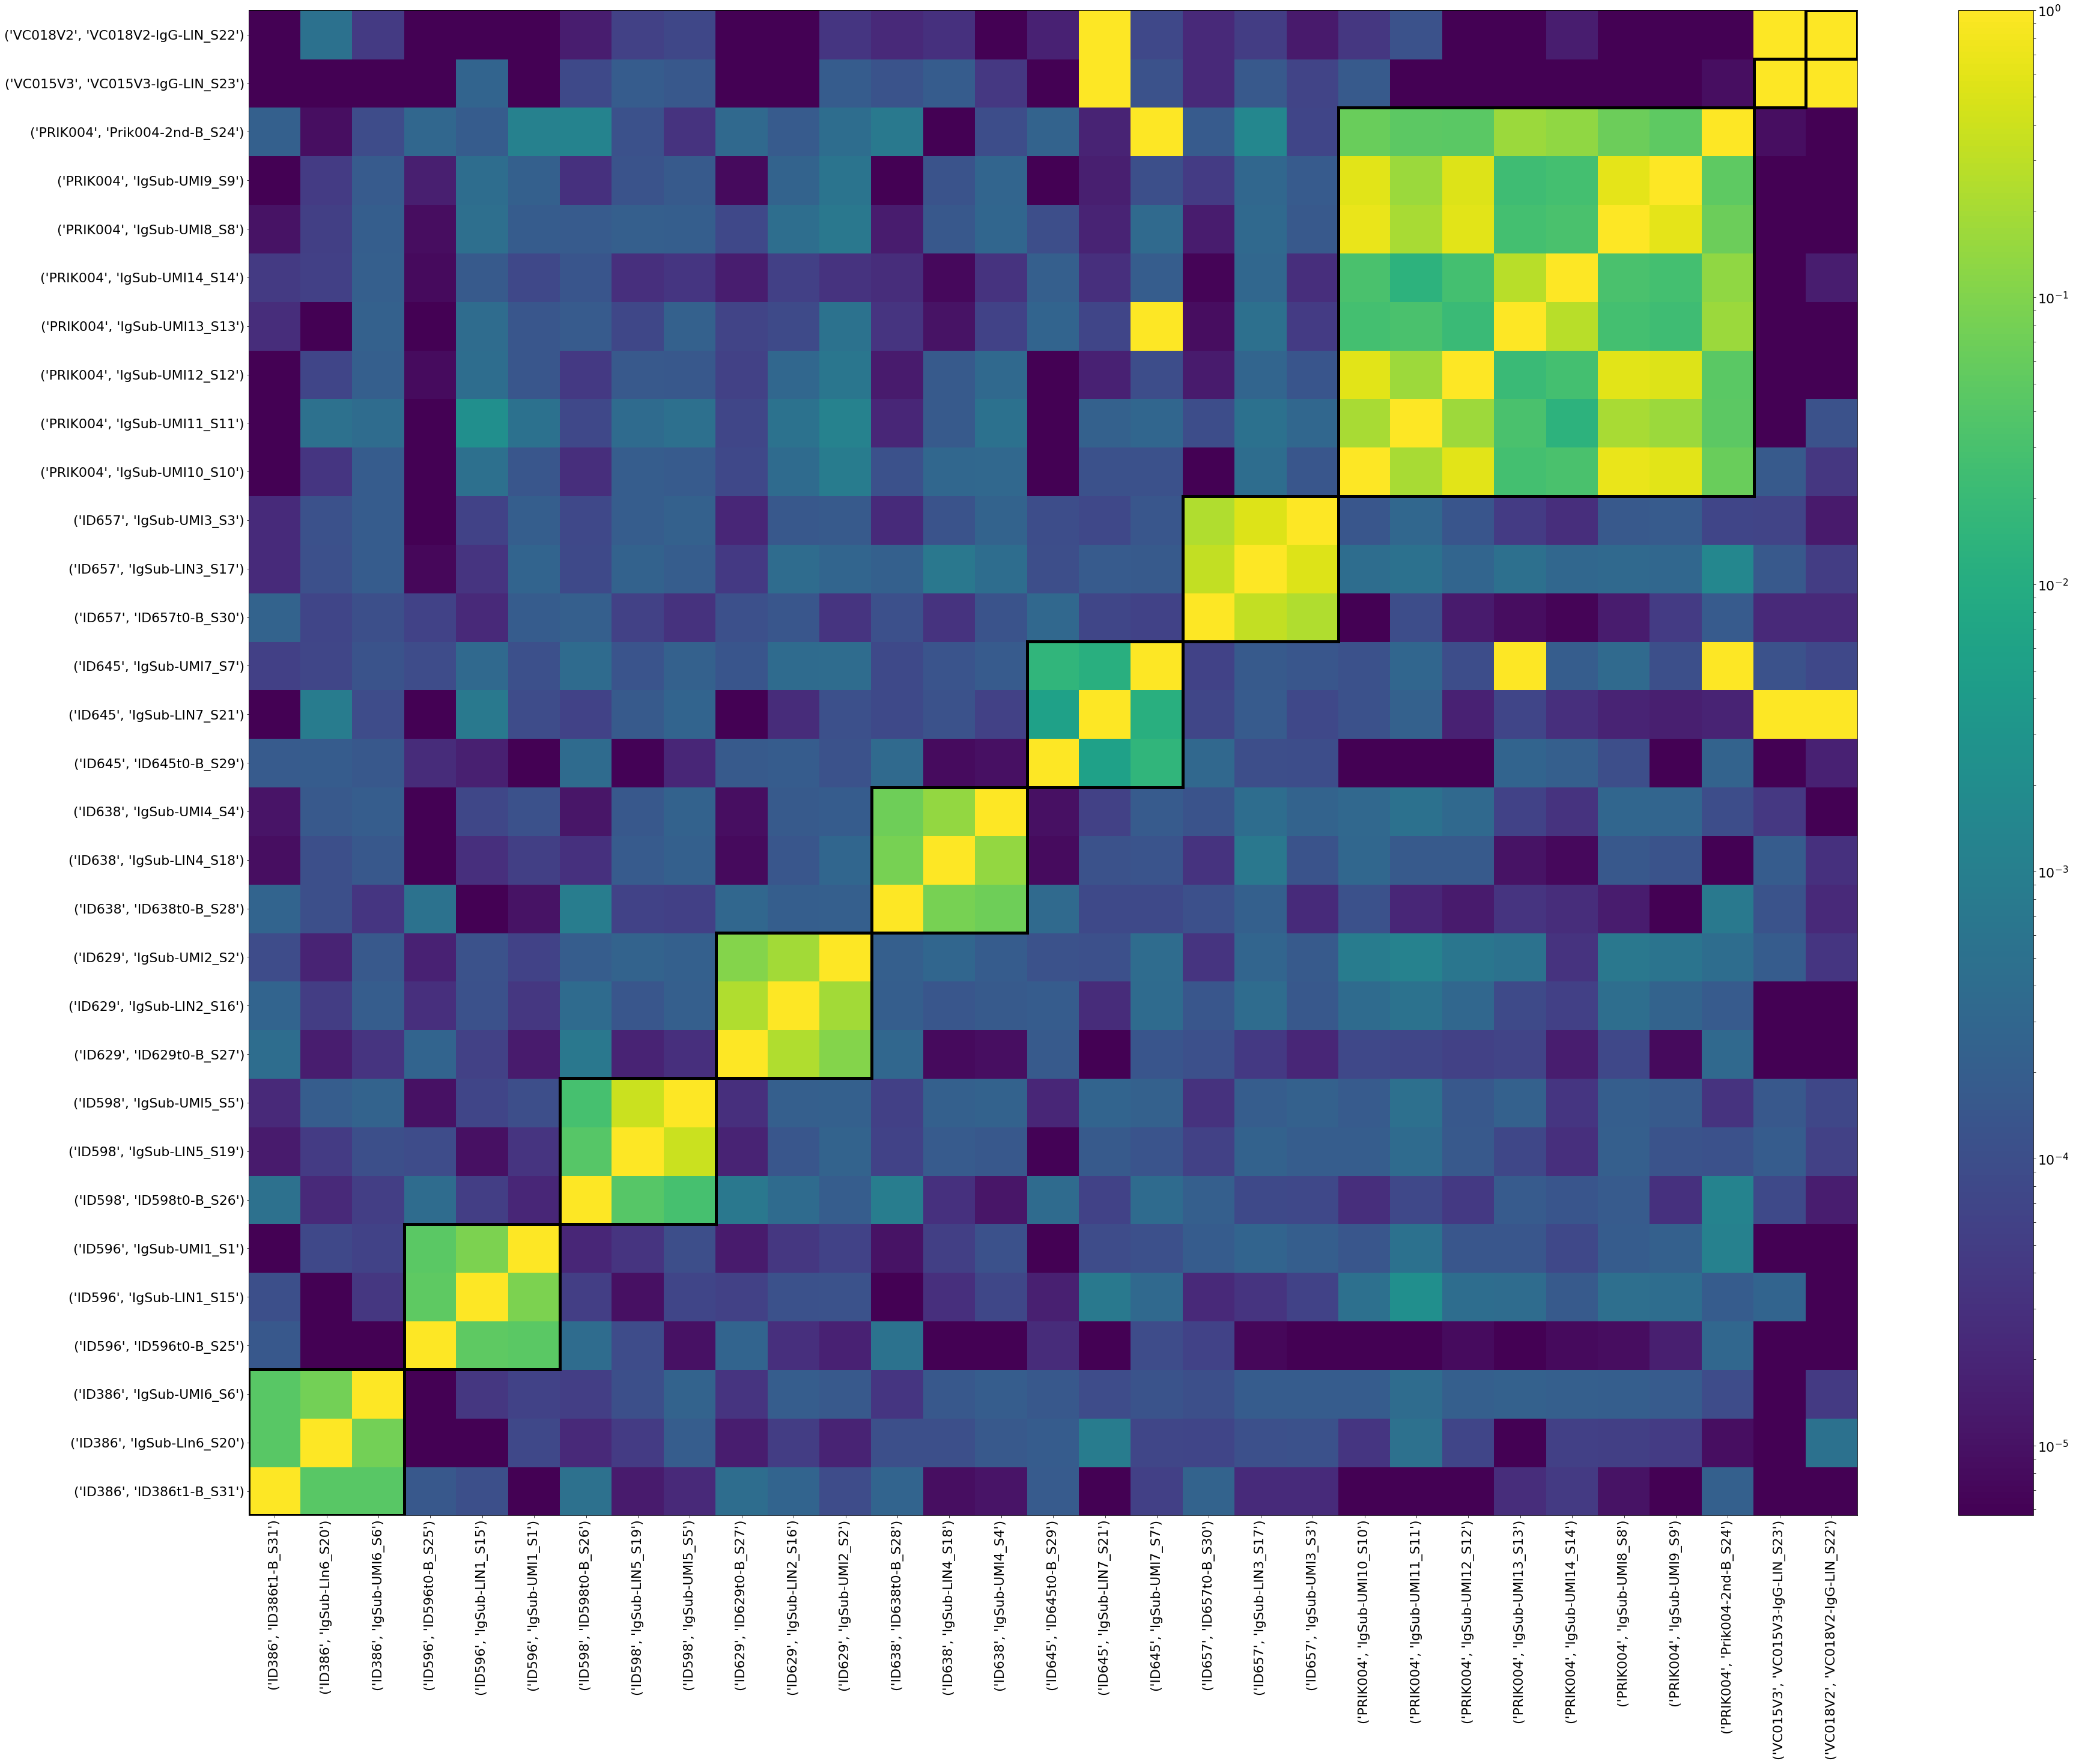

In [22]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)